In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import label_binarize

In [19]:
data = pd.read_csv('data.csv')
data = data.drop(['id','Unnamed: 32'], axis = 1) # удаляем идентификаторы пациентов и пустой столбец

names_of_cols = ['radius', 'texture', 
                 'perimeter', 'area', 
                 'smoothness', 'compactness', 
                 'concavity', 'concave points',
                 'symmetry', 'fractal_dimension']

data = data.replace({'diagnosis':{'M':1, 'B':0}})
data.describe()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,...,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,0.372583,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,...,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946
std,0.483918,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,...,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061
min,0.000000,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,...,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040
25%,0.000000,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,...,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460
50%,0.000000,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,...,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040
75%,1.000000,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,...,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080
max,1.000000,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,...,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500


### Много линейно-зависимых столбцов

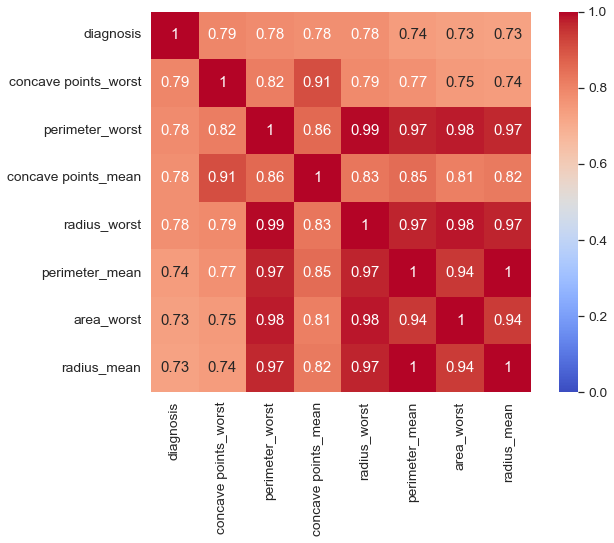

In [3]:
# Оценка признаков на линейную независимость
k = 8
corr = data.corr()
cols = corr.nlargest(k, 'diagnosis')['diagnosis'].index.tolist()
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, yticklabels=cols, xticklabels=cols, 
            square=True, annot=True, 
            cmap=sns.color_palette('coolwarm', 1000), vmin=0, center=0.5)
plt.show()

## Preprocessing
Понятно, что радиус, площадь и периметр очень сильно коррелируют между собой(поэтому оставим один из них), также преобразуем признаки путём усреднения feature_mean и feature_worst между собой. Признаки типа feature_se попробуем отбросить.

In [4]:
for name in names_of_cols:
    data[name] = sum(data[name + '_mean'], data[name + '_worst'])/2
    data.drop(columns=name + '_mean', axis=1, inplace=True) # дропнем ненужные признаки
    data.drop(columns=name + '_worst', axis=1, inplace=True)
    data.drop(columns=name + '_se', axis=1, inplace=True)
    
data.drop(columns=['radius', 'perimeter'], axis=1, inplace=True)

In [5]:
k = 6
corr = data.corr()

# 6 наиболее скореллированных признаков с целевой переменной
cols = corr.nlargest(k, 'diagnosis')['diagnosis'].index.tolist()
cols

['diagnosis', 'concave points', 'area', 'concavity', 'compactness', 'texture']

### Снова оценим матрицу корреляций

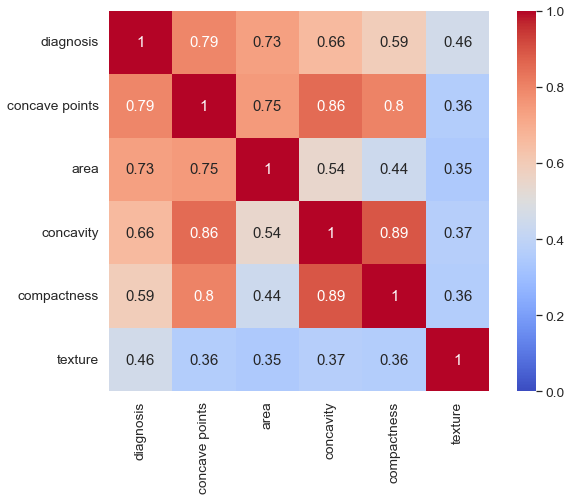

In [6]:
cm = np.corrcoef(data[cols].values.T)
plt.figure(figsize=(10,7))
sns.set(font_scale=1.25)
sns.heatmap(cm, yticklabels=cols, xticklabels=cols, 
            square=True, annot=True, 
            cmap=sns.color_palette('coolwarm', 1000), vmin=0, center=0.5)
plt.show()

### Оценим распределение целевой переменной в попарных scatterplot'ах

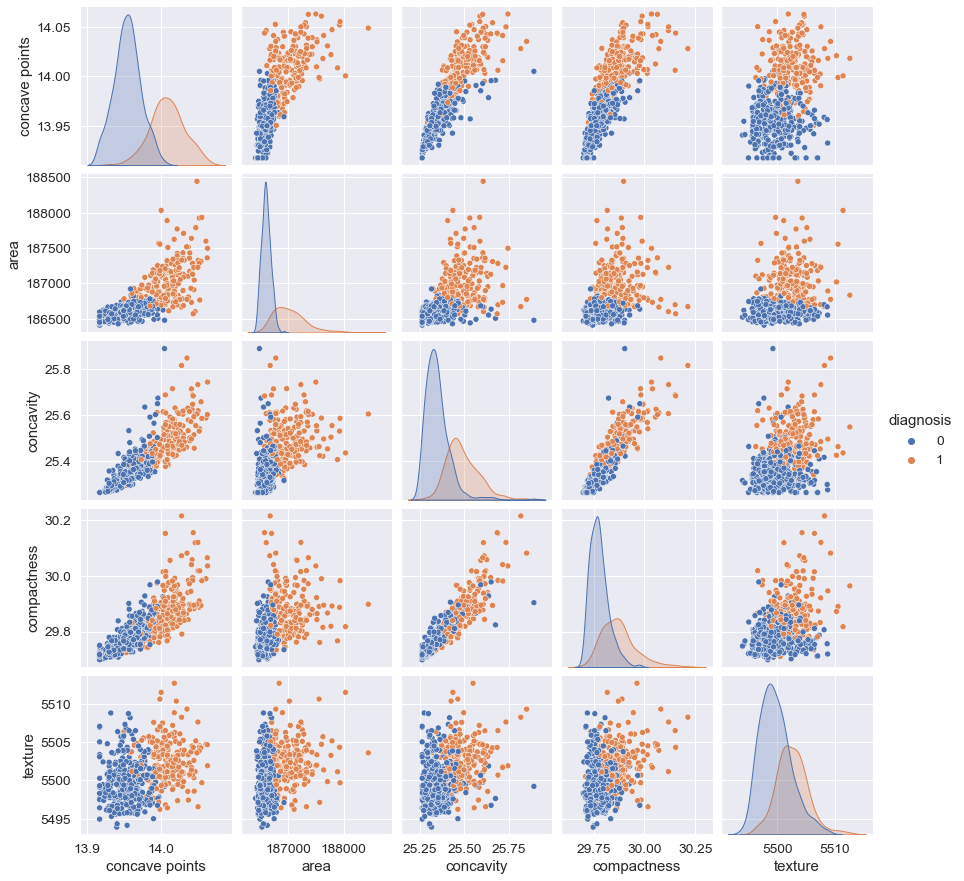

In [7]:
sns.pairplot(data[cols], hue='diagnosis')

### train_test_split

In [8]:
X_train, X_test, y_train, y_test = train_test_split(data.loc[:, 'texture':], data['diagnosis'], 
                                                    test_size=0.3, stratify=data['diagnosis'], 
                                                    random_state=42)
# Отмасштабируем данные
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Простой перебор параметров и оценка метрик качетсва модели knn


Best accuracy 
0.971 
k = 3.0 

Best precision 
0.974 
k = 3.0 

Best recall 
0.964 
k = 3.0 

Best fscore 
0.968 
k = 3.0 


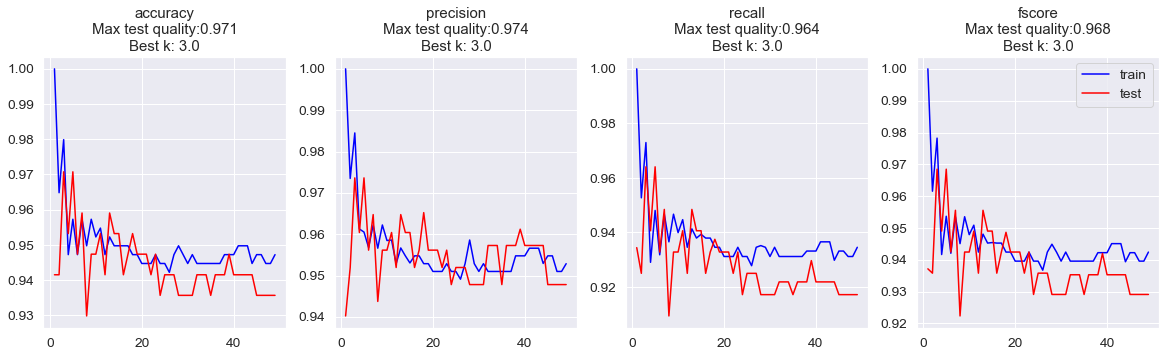

In [9]:
def predict_and_write_metrics(model, X, y, params, report): # запись разных скоров по выбранной сетке параметров
    y_pred = model.predict(X)
    scorings = precision_recall_fscore_support(y, y_pred, average='macro')
    accuracy = accuracy_score(y, y_pred)
    report['accuracy'].append(accuracy)
    report['precision'].append(scorings[0])
    report['recall'].append(scorings[1])
    report['fscore'].append(scorings[2])
    for param in params:
        report[param].append(np.round(params[param], 3))

def show_graph_with_best_param(report_train, report_test, param, param_name):
    # Отображение "лучших" метрик качества и параметров модели для них
    for col in report_test.columns[:-1]:
        print('\nBest', col,'\n{:.3f}'.format(report_test.iloc[report_test[col].argmax()][col]) ,
                f'\n{param_name} =', report_test.iloc[report_test[col].argmax()][param_name], "\n" + "==" * 20)
    
    fig, axs = plt.subplots(1, 4, figsize=(20,5))
    # Отображение измения качества на трейне и тесте для разных метрик качества
    for i, col in enumerate(report_test.columns[:-1]):
        axs[i].plot(param, report_train[col], color='blue', label='train')
        axs[i].plot(param, report_test[col], color='red', label='test')
        axs[i].title.set_text(col + "\n" + "Max test quality:" +
                              f"{np.round(max(report_test[col]), 3)}" + "\n" +
                              f"Best {param_name}: {report_test.iloc[report_test[col].argmax()][param_name]}")
    plt.legend()
    plt.show()
        
neighbors = range(1, 50)
        
report_train = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'k':[]}
report_test = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'k':[]}


# Наивный перебор соседей и оценка метрик
for k in neighbors: 
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train.ravel())
    
    predict_and_write_metrics(knn, X_train, y_train, {'k':k}, report_train)
    predict_and_write_metrics(knn, X_test, y_test, {'k':k}, report_test)

report_train = pd.DataFrame(report_train)
report_test = pd.DataFrame(report_test)

show_graph_with_best_param(report_train, report_test, neighbors, 'k')

### Используем GreedSeachCV для подбора

In [10]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

param_grid = {
        'n_neighbors': range(1, 50)
}

knn = KNeighborsClassifier()


# На основе какого скоринга будут отбираться лучшие параметры при GridSearch'е
scores = ['accuracy', 'precision', 'recall', 'f1'] 

for score in scores:
    print(10 * "==" + f" Подбор гиперпараметров для {score}" + 10 * "==")
    
    clf = GridSearchCV(knn, param_grid, cv=5, scoring=score)
    clf.fit(X_train, y_train.ravel())
    
    print("Best parameters set found on development set:")
    print(clf.best_params_)
    print('\n')
    print("Метрики качества на тестовом датасете:")
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=3))

==================== Подбор гиперпараметров для accuracy====================
Best parameters set found on development set:
{'n_neighbors': 7}


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.946     0.991     0.968       107
           1      0.983     0.906     0.943        64

    accuracy                          0.959       171
   macro avg      0.965     0.948     0.956       171
weighted avg      0.960     0.959     0.959       171

==================== Подбор гиперпараметров для precision====================
Best parameters set found on development set:
{'n_neighbors': 2}


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.922     0.991     0.955       107
           1      0.982     0.859     0.917        64

    accuracy                          0.942       171
   macro avg      0.952     0.925     0.936       171
weighted avg      0.944     0.942 

Получилась точность такая же или хуже, в отличие от наивного перебора числа соседей

## Построим roc и оценим площадь под графиком

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.988


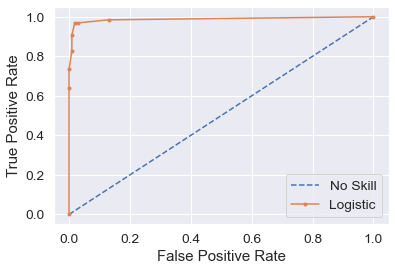

In [11]:
def build_roc(clf, X_train, y_train, X_test, y_test): # Построение roc-графика
    ns_probs = [0 for _ in range(len(y_test))]
    
    clf.fit(X_train, y_train.ravel())

    lr_probs = clf.predict_proba(X_test)
    lr_probs = lr_probs[:, 1]

    ns_auc = roc_auc_score(y_test, ns_probs)
    lr_auc = roc_auc_score(y_test, lr_probs)

    print('No Skill: ROC AUC=%.3f' % ns_auc)
    print('Logistic: ROC AUC=%.3f' % lr_auc)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

knn = KNeighborsClassifier(n_neighbors=7)
build_roc(knn, X_train, y_train, X_test, y_test)

## Вывод: 
### "точность" модели зависит от критерия её оценки

# LogisticRegression

### Оценим по аналогичным методам логит-модель

In [12]:
# метрики качества для Логистической регресии "из коробки"
logit_clf = LogisticRegression(random_state=42)
logit_clf.fit(X_train, y_train.ravel())
y_true, y_pred = y_test, logit_clf.predict(X_test)
print(classification_report(y_true, y_pred, digits=3))

              precision    recall  f1-score   support

           0      0.973     1.000     0.986       107
           1      1.000     0.953     0.976        64

    accuracy                          0.982       171
   macro avg      0.986     0.977     0.981       171
weighted avg      0.983     0.982     0.982       171



### С дефолтными параметры точность уже лучше, чем при knn

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.998


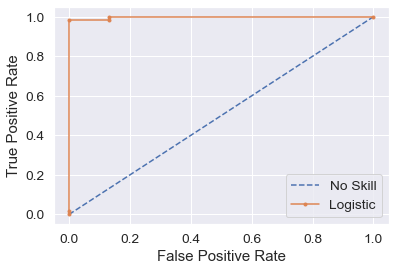

In [13]:
logit_clf = LogisticRegression(random_state=42)
build_roc(logit_clf, X_train, y_train, X_test, y_test)

In [14]:
scores = ['accuracy', 'precision', 'recall', 'f1'] 
Cs = [0.001*n for n in range(1, 10**3, 10)]

for score in scores:
    print(10 * "==" + f" Подбор гиперпараметров для {score}" + 10 * "==")
    clf = LogisticRegressionCV(Cs=Cs, cv=5, scoring=score, random_state=42, solver='liblinear')
    clf.fit(X_train, y_train)
    
    print("Best parameters set found on development set:")
    print(clf.C_)
    print('\n')
    print("Метрики качества на тестовом датасете:")
    
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred, digits=3))

==================== Подбор гиперпараметров для accuracy====================
Best parameters set found on development set:
[0.681]


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.973     1.000     0.986       107
           1      1.000     0.953     0.976        64

    accuracy                          0.982       171
   macro avg      0.986     0.977     0.981       171
weighted avg      0.983     0.982     0.982       171

==================== Подбор гиперпараметров для precision====================
Best parameters set found on development set:
[0.521]


Метрики качества на тестовом датасете:
              precision    recall  f1-score   support

           0      0.964     1.000     0.982       107
           1      1.000     0.938     0.968        64

    accuracy                          0.977       171
   macro avg      0.982     0.969     0.975       171
weighted avg      0.977     0.977     0.976       171

=


Best accuracy 
0.982 
C = 0.671 

Best precision 
0.986 
C = 0.671 

Best recall 
0.977 
C = 0.671 

Best fscore 
0.981 
C = 0.671 


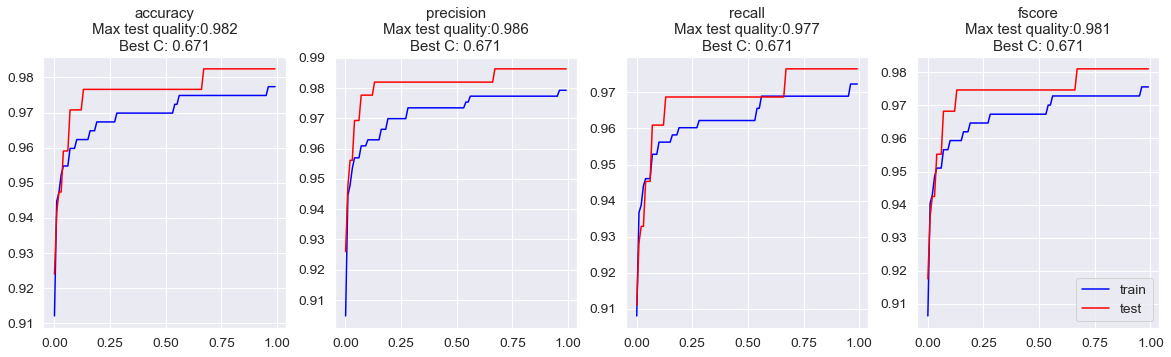

In [15]:
Cs = [0.001*n for n in range(1, 10**3, 10)]
report_train = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'C':[]}
report_test = {'accuracy':[], 'precision':[],'recall':[],'fscore':[],'C':[]}


# Наивный перебор "силы" регуляризации и оценка метрик
for c in Cs: 
    clf = LogisticRegression(C=c, random_state=42, solver = 'liblinear')
    clf.fit(X_train, y_train)
    predict_and_write_metrics(clf, X_train, y_train, {'C': c}, report_train)
    predict_and_write_metrics(clf, X_test, y_test, {'C': c}, report_test)

report_train = pd.DataFrame(report_train)
report_test = pd.DataFrame(report_test)

show_graph_with_best_param(report_train, report_test, Cs, 'C')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.998


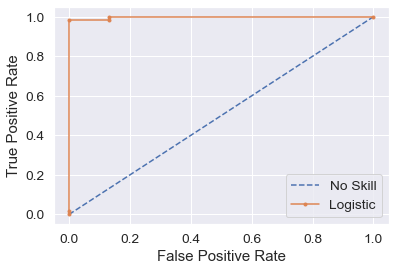

In [16]:
logit_clf = LogisticRegression(random_state=42, C=0.741)
build_roc(logit_clf, X_train, y_train, X_test, y_test)

### Выводы: 
Логистическая регрессия на данном датасете показывает более высокую точность (примерно на 1~2%), чем Knn классификатор 